<a href="https://colab.research.google.com/github/Sette/fifa-23-sorteio/blob/main/Fifa_23_sorteio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [307]:
import os
from urllib.request import urlopen,Request
import pandas as pd
from bs4 import BeautifulSoup
import json
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine
import random
import numpy as np

from google.colab.patches import cv2_imshow
import cv2
# checking if the directory demo_folder2 
# exist or not.
from tqdm.notebook import tqdm
import requests


In [308]:
def get_teams():

  user_agent = 'Mozilla/5.0 (Windows; U; Windows NT 5.1; en-US; rv:1.9.0.7) Gecko/2009021910 Firefox/3.0.7'
  headers={'User-Agent':user_agent,}

  teams_shape = 100
  


  START_URL = "https://www.fifaindex.com/pt-br/teams"

  request=Request(START_URL,None,headers) #The assembled request
  response = urlopen(request)
  data = response.read() # The data u need

  def quant_pags(START_URL):
    """
        FUNÇÃO QUE PEGA VIA CRAWLER A QUANTIDADE DE PÁGINAS A SEREM EXPLORADAS PELO ALGORITMO
    """
    request=Request(START_URL,None,headers) #The assembled request
    response = urlopen(request)
    html = response.read() # The data u need
    bsObj = BeautifulSoup(html, "html5lib")

    links = bsObj.findAll("a", {"class": "page-link"})

    for link in links:
      if (link.getText()) == "Last":
        print(link.attrs['href'])
        cont = int(link.attrs['href'].split("=")[-1:][0])

    return cont

  def get_teams_from_page_link(link):
    request=Request(link,None,headers) #The assembled request
    response = urlopen(request)
    html = response.read() # The data u need
    bsObj = BeautifulSoup(html, "html5lib")

    


    names = bsObj.findAll("td", {"data-title": "Nome"})
    leagues = bsObj.findAll("a", {"class": "link-league"})
    att	= bsObj.findAll("td", {"data-title": "ATA"})
    mid	= bsObj.findAll("td", {"data-title": "MEI"})
    defense = bsObj.findAll("td", {"data-title": "DEF"})
    over = bsObj.findAll("td", {"data-title": "GER"}) 
    img = bsObj.findAll("img", {"class": "team size-5"}) 


    df = pd.DataFrame({"Name":names,"League":leagues,"Att":att,"Mid":mid,"Def":defense,"Over":over,'Img':img})

    
    

    df["Name"] = df["Name"].apply(lambda x: x.getText())
    df["League"] = df["League"].apply(lambda x: x.getText())
    df["Att"] = df["Att"].apply(lambda x: x.getText())
    df["Mid"] = df["Mid"].apply(lambda x: x.getText())
    df["Def"] = df["Def"].apply(lambda x: x.getText())
    df["Over"] = df["Over"].apply(lambda x: x.getText())
    df["Img"] = df["Img"].apply(lambda x: x['src'])
    
    return df



  pages = quant_pags(START_URL)

  def download_teams(pages):
    return pd.concat([get_teams_from_page_link(f'{START_URL}/?page={page}') for page in  range(1,pages+1)])


  teams = download_teams(pages)

  teams.Att = teams.Att.astype(int)
  teams.Mid = teams.Mid.astype(int)
  teams.Def = teams.Def.astype(int)

  teams = teams.reset_index() 

  teams.drop(columns="index",inplace=True)

  womens_leagues = ["Women's","Féminine"]

  def get_sex_league(team):
    if any(x in team.League for x in womens_leagues):
      return "F"
    
    return "M"

  def download_image(image_link):
    
    if not os.path.isdir("imagens"):
    
      # if the demo_folder2 directory is 
      # not present then create it.
      os.makedirs("imagens")

    img_name = image_link.split('/')[-1]
    img_path = os.path.join('imagens',img_name)
    img_data = requests.get(image_link).content
    with open(img_path, 'wb') as handler:
      handler.write(img_data)

    

    return img_path


  teams["Sex"] = [get_sex_league(team) for i,team in teams.iterrows()]

  # teams.drop()


  teams = teams[teams['League'] != 'Libertadores']


  teams=teams.head(teams_shape)

  tqdm.pandas()
  teams['Img'] = teams.Img.progress_apply(lambda x: download_image(x))



  teams_list = [[team[2],team[3],team[4]] for team in teams.values]


  distance_array = pairwise_distances(teams_list, metric='euclidean')

  return teams,distance_array

  


In [344]:
class Telegram_bot():
  def __init__(self):
    self.token = '6138855887:AAHLn60zFzhf6SUvFK7U__sxXMXpFul4EN0'
    self.chat_id = self.get_chat_id(self.token)


  # mostra o id do último grupo adicionado
  def last_chat_id(self):
      try:
          url = "https://api.telegram.org/bot{}/getUpdates".format(self.token)
          response = requests.get(url)
          if response.status_code == 200:
              json_msg = response.json()
              for json_result in reversed(json_msg['result']):
                  message_keys = json_result['message'].keys()
                  if ('new_chat_member' in message_keys) or ('group_chat_created' in message_keys):
                      return json_result['message']['chat']['id']
              print('Nenhum grupo encontrado')
          else:
              print('A resposta falhou, código de status: {}'.format(response.status_code))
      except Exception as e:
          print("Erro no getUpdates:", e)

  # enviar mensagens utilizando o bot para um chat específico
  def send_message(self,msg):
      try:
          data = {"chat_id": self.chat_id, "text": msg}
          url = "https://api.telegram.org/bot{}/sendMessage".format(self.token)
          requests.post(url, data)
      except Exception as e:
          print("Erro no sendMessage:", e)

  def get_chat_id(self,token):
    # id do chat que será enviado as mensagens
    chat_id = self.last_chat_id()
    return chat_id


In [345]:






def sorteia(teams,distance_array,threshold = 5):


  sorteios = 12

  def get_team(df,index):
    return df.iloc.__getitem__(index)
    

  def sorteia_peso(teams,distance_array,threshold):
    while True:

      
      rand_idx = random.randrange(distance_array.shape[0])
      rand_idy = random.randrange(distance_array.shape[1])

      random_num = distance_array[rand_idx][rand_idy]
      sorteio = random_num
      
      # 
      if sorteio <= threshold:
        time1,time2 = get_team(teams,rand_idx),get_team(teams,rand_idy)
        time1['Controle'] = 'Controle 1'
        time2['Controle'] = 'Controle 2'
        return [time1,time2]

 
  def sorteia_confronto(teams):
    while True:
      times = sorteia_peso(teams,distance_array,threshold)
      if times[0].Sex == times[1].Sex and times[0].Name != times[1].Name:
        return times


  def show_team(team,telegram_bot):
    img = cv2.imread(team['Img'], cv2.IMREAD_UNCHANGED)
    cv2_imshow(img)

    print(f"Nome: {team['Name']}")
    print(f"Liga: {team['League']}")
    print(f"Att {team['Att']} - Mid {team['Mid']} - Def {team['Def']}")

    telegram_bot.send_message(f"Nome: {team['Name']}")
    telegram_bot.send_message(f"Liga: {team['League']}")
    telegram_bot.send_message(f"Att {team['Att']} - Mid {team['Mid']} - Def {team['Def']}")



  telegram_bot = Telegram_bot()
  for i in range(sorteios):
    team1,team2 = sorteia_confronto(teams)
    show_team(team1,telegram_bot)
    show_team(team2,telegram_bot)
    telegram_bot.send_message('-----------------------------------')
    



  

In [346]:
# teams, distance_array  = get_teams()

In [347]:
teams.head(2)

,Name,League,Att,Mid,Def,Over,Img,Sex
0,Manchester City,Premier League,85,87,84,85,imagens/10.png,M
1,Real Madrid,LaLiga Santander,85,85,84,85,imagens/243.png,M


/usr/local/lib/python3.8/dist-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1724: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer_missing(indexer, value)


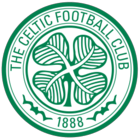

Nome: Celtic
Liga: cinch Prem
Att 74 - Mid 75 - Def 73


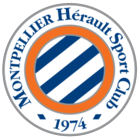

Nome: Montpellier
Liga: Ligue 1 Uber Eats
Att 74 - Mid 76 - Def 73


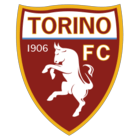

Nome: Torino
Liga: Serie A TIM
Att 76 - Mid 74 - Def 73


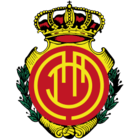

Nome: RCD Mallorca
Liga: LaLiga Santander
Att 75 - Mid 75 - Def 75


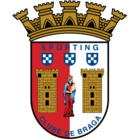

Nome: SC Braga
Liga: Liga Portugal
Att 75 - Mid 77 - Def 74


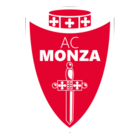

Nome: Monza
Liga: Serie A TIM
Att 76 - Mid 75 - Def 75


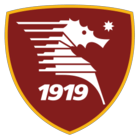

Nome: Salernitana
Liga: Serie A TIM
Att 76 - Mid 73 - Def 72


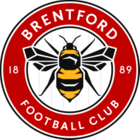

Nome: Brentford
Liga: Premier League
Att 76 - Mid 75 - Def 74


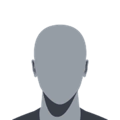

Nome: Bergamo Calcio
Liga: Serie A TIM
Att 78 - Mid 79 - Def 77


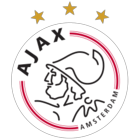

Nome: Ajax
Liga: Eredivisie
Att 79 - Mid 78 - Def 76


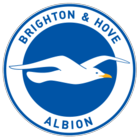

Nome: Brighton
Liga: Premier League
Att 75 - Mid 76 - Def 77


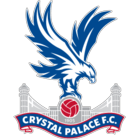

Nome: Crystal Palace
Liga: Premier League
Att 77 - Mid 76 - Def 76


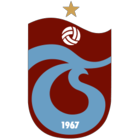

Nome: Trabzonspor
Liga: Süper Lig
Att 74 - Mid 76 - Def 75


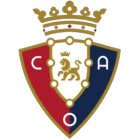

Nome: CA Osasuna
Liga: LaLiga Santander
Att 75 - Mid 77 - Def 76


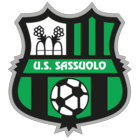

Nome: Sassuolo
Liga: Serie A TIM
Att 77 - Mid 75 - Def 73


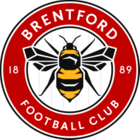

Nome: Brentford
Liga: Premier League
Att 76 - Mid 75 - Def 74


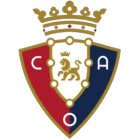

Nome: CA Osasuna
Liga: LaLiga Santander
Att 75 - Mid 77 - Def 76


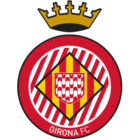

Nome: Girona FC
Liga: LaLiga Santander
Att 77 - Mid 76 - Def 74


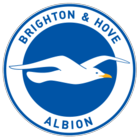

Nome: Brighton
Liga: Premier League
Att 75 - Mid 76 - Def 77


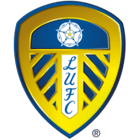

Nome: Leeds United
Liga: Premier League
Att 77 - Mid 76 - Def 75


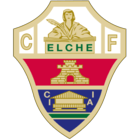

Nome: Elche CF
Liga: LaLiga Santander
Att 75 - Mid 73 - Def 73


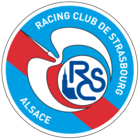

Nome: Strasbourg
Liga: Ligue 1 Uber Eats
Att 77 - Mid 74 - Def 73


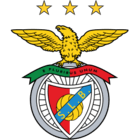

Nome: SL Benfica
Liga: Liga Portugal
Att 80 - Mid 79 - Def 78


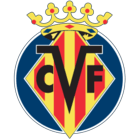

Nome: Villarreal CF
Liga: LaLiga Santander
Att 82 - Mid 80 - Def 79


In [348]:
sorteia(teams,distance_array,threshold = 3)